# RemoveBG

IA para eliminar fondos de imágenes

# Temas a tratar

* Redes neuronales convolucionales.
* Algoritmos de segmentación.
* Cuantización de modelos.
* Backends de keras.
* SAM (Segment Anything)
* Uso de modelos específicos.
* Variantes con Unet y Silueta

# Objetivo

Desarrollar un modelo de inteligencia artificial (IA) que dada una imagen identique el elemento que se quiere representar.

# Problema

Eliminar fondos de imágenes siempre ha sido un problema relevante que la mayor parte de la historia ha sido resuelto con soluciones de hardware como chroma keys o incluso recortes de imágenes y escaneos. En la actualidad la computación ha avanzado y existen herramientas tanto en local como online para solucionar el problema, sin embargo nada garantiza que las imágenes sean privadas e incluso que sean usadas con otros fines.

# Solución

Ante esto, se plantea crear una IA para eliminar fondos de imágenes que al ser propia nos garantiza la privacidad y costos que se desea.

# Desarrollo

In [ ]:
# Instalamos dependencias

# Keras para manejo de modelos
!pip install -Uq keras-cv
!pip install -Uq keras

# Extensión de Jupyter notebook para dibujar recuadros en imágenes
!pip install jupyter_bbox_widget

# GroundingDINO como modelo para buscar elementos dentro de una imagen y señalizarlos
!pip install -U git+https://github.com/IDEA-Research/GroundingDINO.git
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth
!wget -q https://raw.githubusercontent.com/IDEA-Research/GroundingDINO/v0.1.0-alpha2/groundingdino/config/GroundingDINO_SwinT_OGC.py

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 10.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 13.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 367.8/367.8 kB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 13.1 MB/s eta 0:00:00
  Cloning https://github.com/IDEA-Research/GroundingDINO.git to /tmp/pip-req-build-j7b0qcnf
  Running command git clone --filter=blob:none --quiet https://github.com/IDEA-Research/GroundingDINO.git /tmp/pip-req-build-j7b0qcnf
  Resolved http

## Selección del backend

Keras es una librería que permite definir modelos usando un lenguaje de alto nivel como Python, pero por dentro, hace unas transformaciones parecidas a las compilaciones para correr los modelos de una manera u otra.

Un backend de Keras es una biblioteca de computación numérica que se utiliza para ejecutar los modelos de aprendizaje profundo definidos en Keras. Por el momento solo existen 3:

- Tensorflow: El backend original con código bastante complejo
- Pytorch: Su compilación es más fácil de entender e incluso ha logrado tener mejor rendimiento en muchos modelos nuevos.
- JAX: El más nuevo de todos, tiene abstracciones sobre el rendimiento que facilitan la definición de modelos.

[Según Keras](https://keras.io/getting_started/benchmarks/), no hay backend perfecto para todo, pero basta con ver el favoritismo del [creador de Keras](https://twitter.com/fchollet) por JAX para ser persuadidos a elegirlo.

En este caso se escogerá JAX, porque en los benchmarks de Keras arrojó ser 50% más rápido que el resto.



In [ ]:
import os

# (Opcional) Cambiamos el backend porque las inferencias se hacen un 50% más rápido (https://keras.io/getting_started/benchmarks/)
os.environ["KERAS_BACKEND"] = "jax"

## Cuantización

La cuantización de modelos es una técnica para reducir la precisión de los pesos y activaciones de un modelo, con el objetivo de mejorar el rendimiento y la eficiencia de la inferencia.

Los pesos de los modelos suelen estar representados por floats de 32 o 64 bits. Estos deben primero almacenarse en memoria y luego pasar por el procesamiento. La cuantización busca reducir esa precisión a menos bits 8, 16, etc. Esto hace que el mismo modelo, ocupe mucha menos memoria y espacio en el búfer, permitiendo que sea más manejable por dispositivos de bajos recursos como teléfonos y sistemas embebidos, además de permitir el procesamiento de más datos en menos iteraciones por parte de los dispositivos normales.

El coste de todo esto es la precisión, mientras menos bits menos precisión en los pesos y por lo tanto es probable que no se ajuste tan bien a como se ajustaría con mayores precisiones.

Para este caso, vamos a cambiar los pesos de keras para usar 16 bits.

In [ ]:
import keras
from keras import ops
import keras_cv

# (Opcional) Usar floats de 16 bits hace que sea más rápido el modelo a costa de precisión
keras.mixed_precision.set_global_policy("mixed_float16")

Definimos funciones de ayuda

In [ ]:
import timeit
import numpy as np
import matplotlib.pyplot as plt
import base64

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels == 1]
    neg_points = coords[labels == 0]
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25,
    )


def show_box(box, ax):
    box = box.reshape(-1)
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(
        plt.Rectangle((x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2)
    )


def inference_resizing(image, pad=True):
    # Compute Preprocess Shape
    image = ops.cast(image, dtype="float32")
    old_h, old_w = image.shape[0], image.shape[1]
    scale = 1024 * 1.0 / max(old_h, old_w)
    new_h = old_h * scale
    new_w = old_w * scale
    preprocess_shape = int(new_h + 0.5), int(new_w + 0.5)

    # Resize the image
    image = ops.image.resize(image[None, ...], preprocess_shape)[0]

    # Pad the shorter side
    if pad:
        pixel_mean = ops.array([123.675, 116.28, 103.53])
        pixel_std = ops.array([58.395, 57.12, 57.375])
        image = (image - pixel_mean) / pixel_std
        h, w = image.shape[0], image.shape[1]
        pad_h = 1024 - h
        pad_w = 1024 - w
        image = ops.pad(image, [(0, pad_h), (0, pad_w), (0, 0)])
        # KerasCV now rescales the images and normalizes them.
        # Just unnormalize such that when KerasCV normalizes them
        # again, the padded values map to 0.
        image = image * pixel_std + pixel_mean
    return image

# restore original size

def restore_original_size(image, original_size):
  h, w = original_size
  image = ops.image.resize(image[None, ...], (h, w))[0]
  return image


def encode_image(filepath):
    with open(filepath, 'rb') as f:
        image_bytes = f.read()
    encoded = str(base64.b64encode(image_bytes), 'utf-8')
    return "data:image/jpg;base64,"+encoded

Keras entre sus utilidades posee [KerasCV](https://keras.io/api/keras_cv/models/), una librería que permite trabajar con modelos de visión por computador. De hecho la semana pasada se usó uno, MobilenetV2. En esta semana se quiere un modelo de segmentación, para lo que se ofrecen los presets DeepLabV3Plus, SegFormerB0 y SAM.

Se va a usar SAM, pues es el modelo más popular a la fecha para todos los problemas de segmentación

In [ ]:
model = keras_cv.models.SegmentAnythingModel.from_preset("sam_huge_sa1b")

100%|██████████| 3.38k/3.38k [00:00<00:00, 7.71MB/s]
100%|██████████| 2.39G/2.39G [00:47<00:00, 54.5MB/s]


--2024-04-30 13:59:05--  https://t1.uc.ltmcdn.com/es/posts/3/0/1/se_puede_anadir_agua_al_pienso_de_los_perros_51103_600.jpg
Resolving t1.uc.ltmcdn.com (t1.uc.ltmcdn.com)... 212.102.46.9, 2a02:6ea0:d800::2
Connecting to t1.uc.ltmcdn.com (t1.uc.ltmcdn.com)|212.102.46.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 33026 (32K) [image/jpeg]
Saving to: ‘dog.jpg’

dog.jpg             100%[===================>]  32.25K  --.-KB/s    in 0.007s  

2024-04-30 13:59:05 (4.23 MB/s) - ‘dog.jpg’ saved [33026/33026]



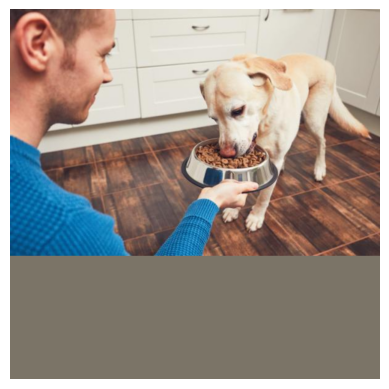

In [ ]:
# Descagamos la imagen

!wget https://t1.uc.ltmcdn.com/es/posts/3/0/1/se_puede_anadir_agua_al_pienso_de_los_perros_51103_600.jpg -O dog.jpg


# Cargamos la imagen
image = np.array(keras.utils.load_img("dog.jpg"))
image = inference_resizing(image)
image = ops.convert_to_numpy(image)

plt.figure()
plt.imshow(image / 255.0)
plt.axis("off")
plt.show()
plt.imsave('dog_scaled.jpg', image / 255.0)

Lastimosamente, SAM no funciona por sí solo, necesita que se le indique a través de un punto, una caja o un texto lo que debe separar del resto.

Para ello vamos a usar un Widget de Jupyter para dibujar un recuadro en la imagen que le sirva al modelo para saber qué queremos segmentar.

In [ ]:
IS_COLAB = True

if IS_COLAB:
    from google.colab import output
    output.enable_custom_widget_manager()

from jupyter_bbox_widget import BBoxWidget

widget = BBoxWidget()
widget.image = encode_image('dog_scaled.jpg')
widget

BBoxWidget(colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#b…

In [ ]:
widget.bboxes

[{'x': 5, 'y': 9, 'width': 625, 'height': 712, 'label': ''}]

## Preprocesamiento de los datos

Ya con la información de las cajas, podríamos entrenar el modelo, no obstante, SAM funciona introduciendo las cajas de la siguiente forma `[[x1, y1], [x2, y2]]` y el widget nos da las cajas en la forma `[{'x': x, 'y': y, 'width': width, 'height': height, 'label': ''}]` por lo que necesitamos trabajar estos datos

In [ ]:
import numpy as np

# default_box is going to be used if you will not draw any box on image above
default_box = {'x': 286, 'y': 47, 'width': 309, 'height': 315, 'label': ''}

box = widget.bboxes[0] if widget.bboxes else default_box
input_box = np.array([[box['x'], box['y']], [box['x'] + box['width'], box['y'] + box['height']]])

Listo, ahora solo es cuestión de usar el modelo SAM, para predecir la máscara en la caja indicada. Para ello se hace la inferencia como indica la [documentación](https://keras.io/api/keras_cv/models/tasks/segment_anything/)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step


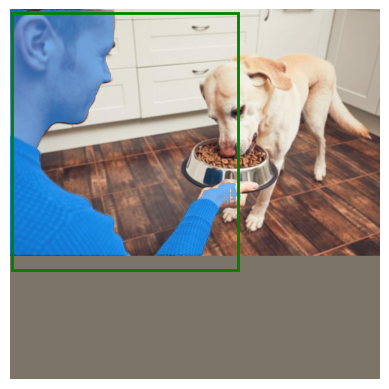

In [ ]:
# Predeicmos las máscaras
outputs = model.predict(
    {"images": image[np.newaxis, ...], "boxes": input_box[np.newaxis, np.newaxis, ...]}
)

# Tomamos la primera máscara
mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
mask = ops.convert_to_numpy(mask) > 0.0

plt.figure()
plt.imshow(ops.convert_to_numpy(image) / 255.0)
show_mask(mask, plt.gca())
show_box(input_box, plt.gca())
plt.axis("off")
plt.show()

Vamos a ver más a fondo todo, primero vamos a revisar qué era esa máscara que obtuvimos de la predicción del modelo

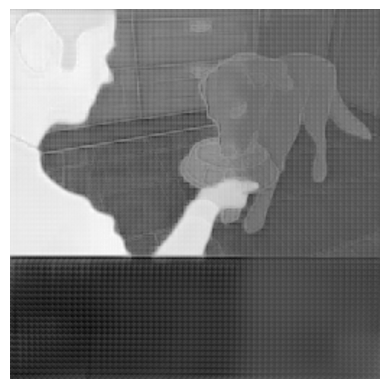

In [ ]:
original_mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]
plt.figure()
plt.imshow(original_mask, cmap='gray')
plt.axis("off")
plt.show()

Como vemos, no da una máscara exacta, sino valores de todo tipo que generan una escala de grises. Para ello simplemente hacemos que los positivos sean los que deseamos y los negativos el resto.


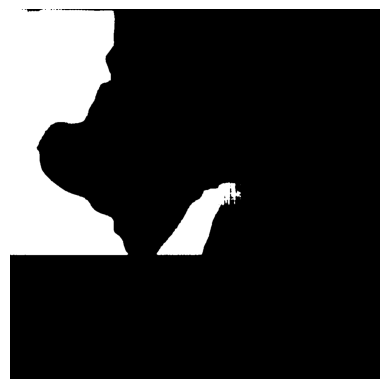

In [ ]:
mask = ops.convert_to_numpy(original_mask) > 0.0
plt.figure()
plt.imshow(mask, cmap='gray')
plt.axis("off")
plt.show()

Como vemos, el perro termina siendo blanco y el resto negro.

Ya con la máscara del perro, podemos eliminar su fondo, creando un fondo transparente, eliminar los valores que coincidan con el perro, y poner los valores de la imagen original

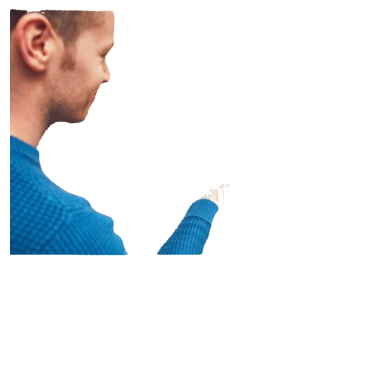

In [ ]:
segmentation_mask = inference_resizing(outputs["masks"][0][0][..., None], pad=False)[..., 0]

# Creamos una máscara binaria de acuero a la máscara (lo que hicimos para eliminar grises)
binary_mask = np.where(segmentation_mask > 0.5, 1, 0)

# Creamos un fondo blanco del tamaño de la imagen
white_background = np.ones_like(image) * 255

# Al fobdi blanco solo agregamos la parte de la imagen que nos dio la máscara
new_image = white_background * (1 - binary_mask[..., np.newaxis]) + image * binary_mask[..., np.newaxis]

# Dibujamos
plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()

Listo, aunque claramente es molesto tener que marcar nuestro objetivo cada vez que queremos segmentar algo, para ello SAM permite introducir prompts de texto para indicarle qué se quiere segmentar. No obstante, prefiero aprovechar esta oportunidad para presentar un modelo adicional: GroundingDINO.

GrounDINO, al igual que Yolo y otros modelos similares, permite identificar elementos dentro de una imagen, y señalarlos dado una entrada de texto. Vamos a verlo.

In [ ]:
from groundingdino.util.inference import Model as GroundingDINO

# Configuramos el modelo
CONFIG_PATH = "GroundingDINO_SwinT_OGC.py"
WEIGHTS_PATH = "groundingdino_swint_ogc.pth"

grounding_dino = GroundingDINO(CONFIG_PATH, WEIGHTS_PATH)

final text_encoder_type: bert-base-uncased


The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Supongamos que queremos eliminar el fondo y dejar a la persona alimentando a su perro. Para ello, le decimos a grounddino que queremos al perro, la comida, el plato y el humano.

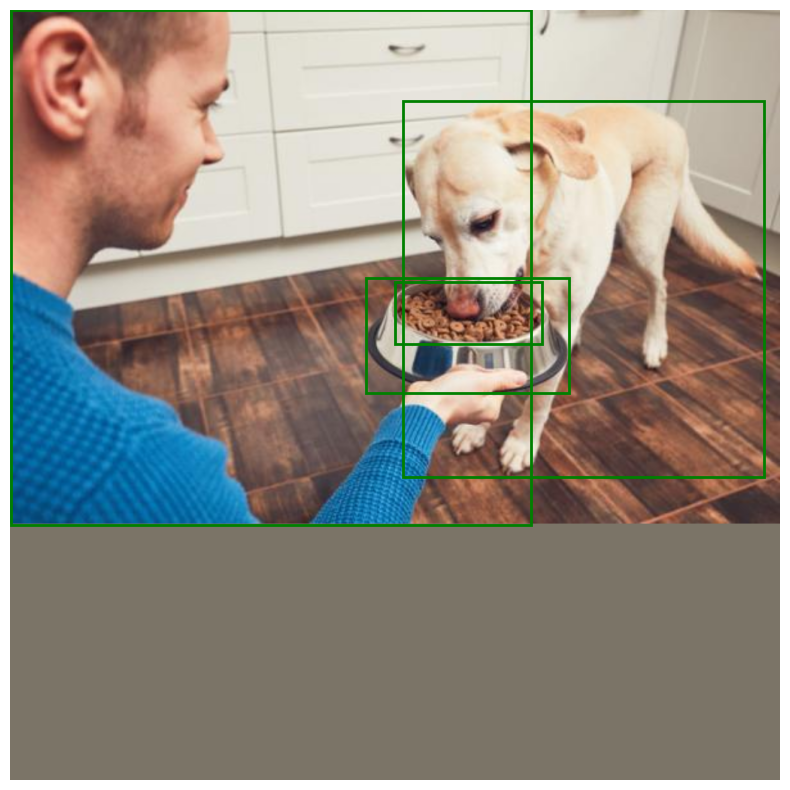

In [ ]:
dog = grounding_dino.predict_with_caption(image.astype(np.uint8), "dog")
food = grounding_dino.predict_with_caption(image.astype(np.uint8), "food")
plate = grounding_dino.predict_with_caption(image.astype(np.uint8), "plate")
human = grounding_dino.predict_with_caption(image.astype(np.uint8), "human")
boxes = np.array([np.array(dog[0].xyxy), np.array(food[0].xyxy), np.array(plate[0].xyxy), np.array(human[0].xyxy)])

# Mostramos el resultado
plt.figure(figsize=(10, 10))
plt.imshow(ops.convert_to_numpy(image) / 255.0)
for box in boxes:
  show_box(box, plt.gca())
plt.axis("off")
plt.show()

Como vemos, es como si hubiésemos marcado manualmente las cajas, pero ya lo hizo una IA por nosotros.  Groundino permite encontrar todos los matches, pero solo muestra una caja porque creamos las boxes indicando el primer índice que era válido para una clase `dog[0]`, `food[0]`, etc. Pero si se quiere todos, simplemente se agrega a la lista.

Ahora vamos a ver qué nos dice SAM sobre la máscara de este input

In [ ]:
outputs = model.predict(
    {
        "images": np.repeat(image[np.newaxis, ...], boxes.shape[0], axis=0),
        "boxes": boxes.reshape(-1, 1, 2, 2),
    },
    batch_size=1,
)

4/4 ━━━━━━━━━━━━━━━━━━━━ 9s 470ms/step


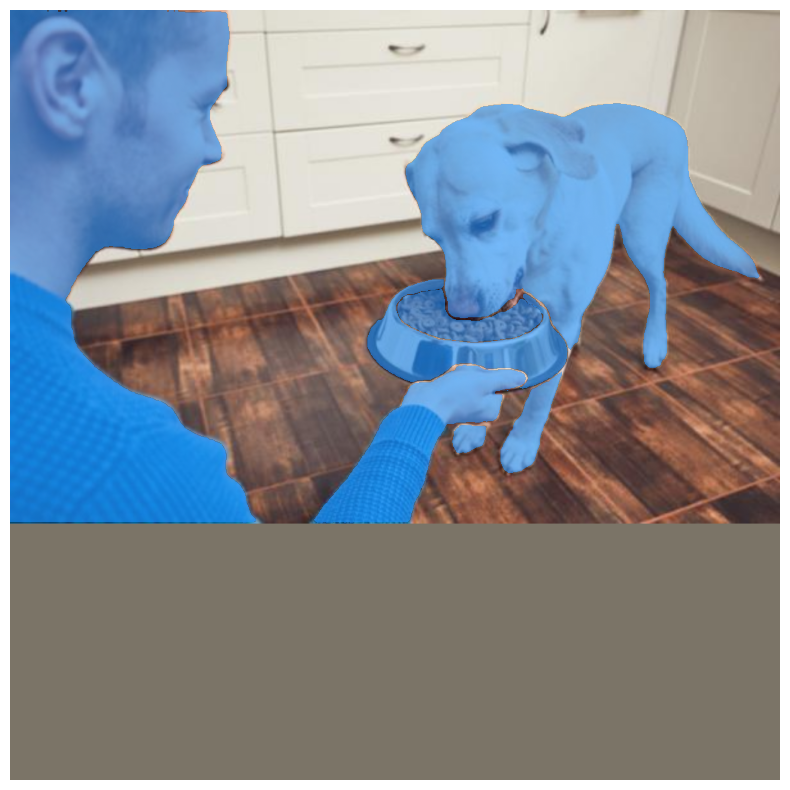

In [ ]:
plt.figure(figsize=(10, 10))
plt.imshow(image / 255.0)

for i in range(outputs["masks"].shape[0]):
    mask = inference_resizing(outputs["masks"][i][0][..., None], pad=False)[..., 0]
    mask = ops.convert_to_numpy(mask) > 0.0
    show_mask(mask, plt.gca())

plt.axis("off")
plt.show()

Como se ve en menos de la mitad de un segundo, SAM fue capaz de identificar la máscara para todas las cajas que creó GroundDino. ¡Ya solo nos faltaría eliminar el fondo!

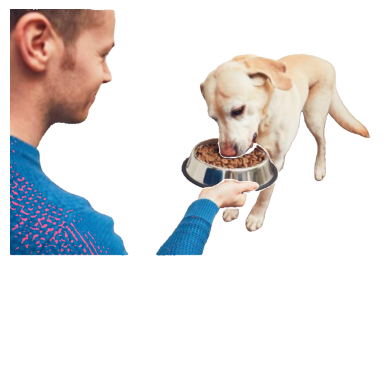

In [ ]:
# Aplicar todas las máscaras

import matplotlib.pyplot as plt
import numpy as np
new_image = np.ones_like(image) * 255

for i in range(outputs["masks"].shape[0]):
    mask = inference_resizing(outputs["masks"][i][0][..., None], pad=False)[..., 0]
    mask = ops.convert_to_numpy(mask) > 0.0
    new_image += image * mask[..., np.newaxis]

plt.imshow(new_image.astype(np.uint8))
plt.axis('off')
plt.show()


Listo. Ya tenemos una IA que elimina el fondo de imágenes, vamos a desplegarla.

## Despliegue

In [ ]:
# Descarga imagen de internet con python

import requests
from io import BytesIO
from PIL import Image
import matplotlib.pyplot as plt
from urllib.request import urlopen
import numpy as np


def download_image(url: str):
  # Send a GET request to the URL
  response = requests.get(url)

  # Check if the request was successful
  if response.status_code == 200:
      # Read the image data from the response
      image_data = response.content

      # Create an image object from the data
      image = Image.open(BytesIO(image_data)).convert("RGB")

      original_shape = image.size

      image = inference_resizing(image)

      data = ops.convert_to_numpy(image)

      # Return the data of the image
      return data, original_shape
  else:
      print("Failed to download the image.", response.status_code)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def apply_masks(src_image, outputs):
  new_image = np.ones_like(src_image) * 255
  print(outputs["masks"].shape[0])
  for i in range(outputs["masks"].shape[0]):
      mask = inference_resizing(outputs["masks"][i][0][..., None], pad=False)[..., 0]
      mask = ops.convert_to_numpy(mask) > 0.0
      new_image += src_image * mask[..., np.newaxis]

  return new_image

In [ ]:
from PIL import Image

# Hace el reverse del rezizing para que la imagen vuelva a su tamaño original
# y devuelve una PIL image que servirá para obtener los bytes
def reverse_inference_resizing(image, original_shape, pad=True):
  ow, oh = original_shape[0], original_shape[1]
  scale = 1024 * 1.0 / max(ow, oh)
  new_h = oh * scale
  new_w = ow * scale
  preprocess_shape = int(new_h + 0.5), int(new_w + 0.5)
  # Unpad the image
  if pad:
      image = image[:preprocess_shape[0], :preprocess_shape[1], :]

  img = Image.fromarray(image.astype(np.uint8))
  img = img.resize(original_shape)
  return img

In [ ]:
# La función que hace todo y eliminar el fondo de una imagen
def remove_bg(url: str):
  image, shape = download_image(url)
  boxes = grounding_dino.predict_with_caption(image.astype(np.uint8), "main character")[0].xyxy
  outputs = model.predict(
      {
          "images": np.repeat(image[np.newaxis, ...], boxes.shape[0], axis=0),
          "boxes": boxes.reshape(-1, 1, 2, 2),
      },
      batch_size=1,
  )
  image = apply_masks(image, outputs)
  return reverse_inference_resizing(image, shape)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1


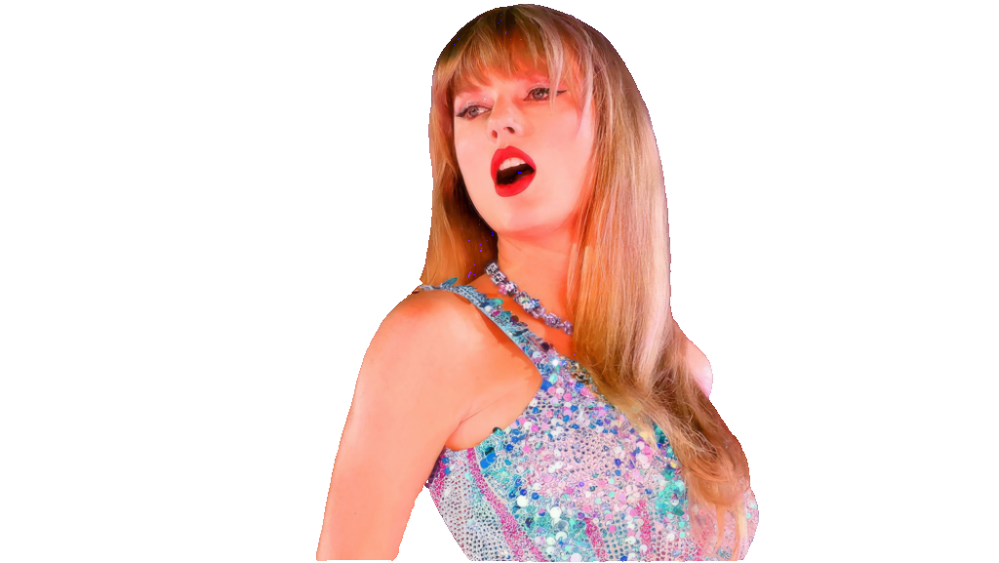

In [ ]:
img = remove_bg('https://variety.com/wp-content/uploads/2024/02/Screen-Shot-2024-02-28-at-12.40.18-PM.png?w=1000&h=563&crop=1')
img

In [ ]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [ ]:
!pip install --ignore-installed Flask==3.0.0 pyngrok==7.1.2
ngrok_key = "Coloca tu clave de ngrok aquí"
port = 5000

from pyngrok import ngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.7/99.7 kB 2.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.3/227.3 kB 20.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.3/133.3 kB 16.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 10.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.5/705.5 kB 45.6 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0+cu121 requires nvidia-cublas-cu12==12.1.3.1; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-cupti-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which is not installed.
torch 2.3.0+cu121 requires nvidia-cuda-nvrtc-cu12==12.1.105; platform_system == "Linux" and platform_machine == "x86_64", which

In [ ]:
from IPython.display import IFrame
IFrame(src="https://projects.rolandoandrade.me/removebg/", width=800, height=600)

In [ ]:
ngrok.set_auth_token(ngrok_key)
ngrok.connect(port)

<NgrokTunnel: "https://e246-35-247-165-246.ngrok-free.app" -> "http://localhost:5000">

In [ ]:
from flask import Flask, request, jsonify, Response, send_file
import json
import io

app = Flask(__name__)

@app.route("/")
def hello():
  image_url = request.args.get('image_url')
  image= remove_bg(image_url)
  image_io = io.BytesIO()
  image.save(image_io, format="PNG")
  image_io.seek(0)

  response = send_file(
      image_io, mimetype="image/jpeg", as_attachment=True, download_name="image.jpg"
  )

  response.headers = [('Access-Control-Allow-Origin', '*')]
  return response

if __name__ == '__main__':
    app.run(port = port)

 * Serving Flask app '__main__'
 * Debug mode: off


INFO:werkzeug:WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on http://127.0.0.1:5000
INFO:werkzeug:Press CTRL+C to quit
INFO:werkzeug:127.0.0.1 - - [03/Jun/2024 12:08:46] "GET /?image_url=https://variety.com/wp-content/uploads/2024/02/Screen-Shot-2024-02-28-at-12.40.18-PM.png?w=1000&h=563&crop=1 HTTP/1.1" 200 -
INFO:werkzeug:127.0.0.1 - - [03/Jun/2024 12:08:57] "GET /?image_url=https://cdn1.dotesports.com/wp-content/uploads/sites/3/2020/10/30172208/pikachu-world-cap.jpg HTTP/1.1" 200 -


# Usando un modelo específico para la tarea

Pese a que SAM es bueno para segmentar lo que sea, hay modleos muchos mejores para la tarea específica de eliminar fondos. El más popular a la fecha en HuggingFace es RMBG-1.4.

Ahora, vamos a usar RMBG usando la API de transformers para ver cómo se resolvería la tarea.

[Transformers](https://huggingface.co/docs/transformers/en/index) es una API que permite ejecutar centenas de modelos con el mismo código, solo cambiando los parámetros del pipeline, lo que hace muy fácil desarrollar.

Lo mejor de todo, es que HuggingFace suele ya incluir el código para usar los modelos, por lo que ni hace falta saber programar

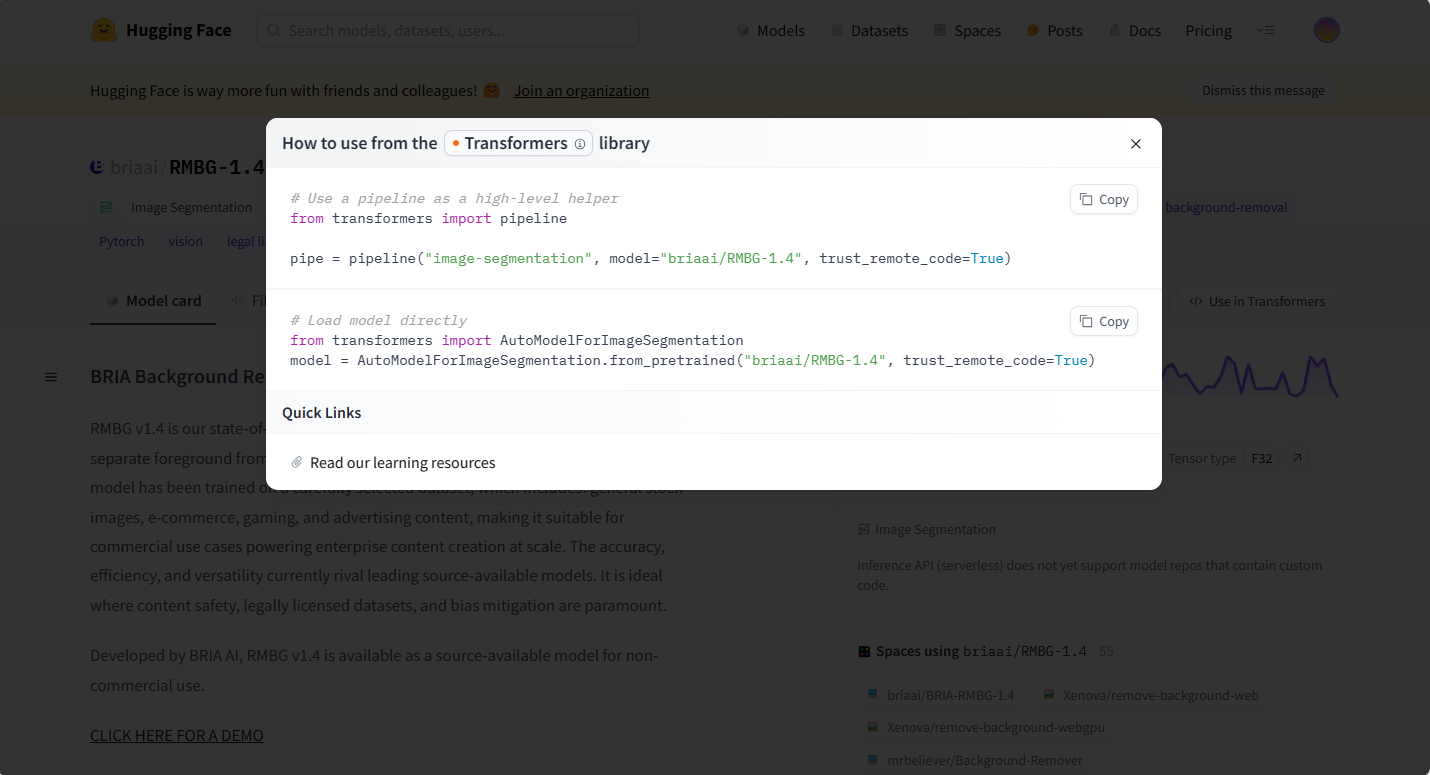



Creamos el pipeline como nos indica HF

In [ ]:
from transformers import pipeline

# Creamos un pipe de segmentación de imágenes con el modelo RMBG-1.4
pipe = pipeline("image-segmentation", model="briaai/RMBG-1.4", trust_remote_code=True)

config.json:   0%|          | 0.00/548 [00:00<?, ?B/s]

MyConfig.py:   0%|          | 0.00/326 [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-1.4:
- MyConfig.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


MyPipe.py:   0%|          | 0.00/2.92k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-1.4:
- MyPipe.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


briarmbg.py:   0%|          | 0.00/13.1k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/briaai/RMBG-1.4:
- briarmbg.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/176M [00:00<?, ?B/s]

Descargamos la imagen

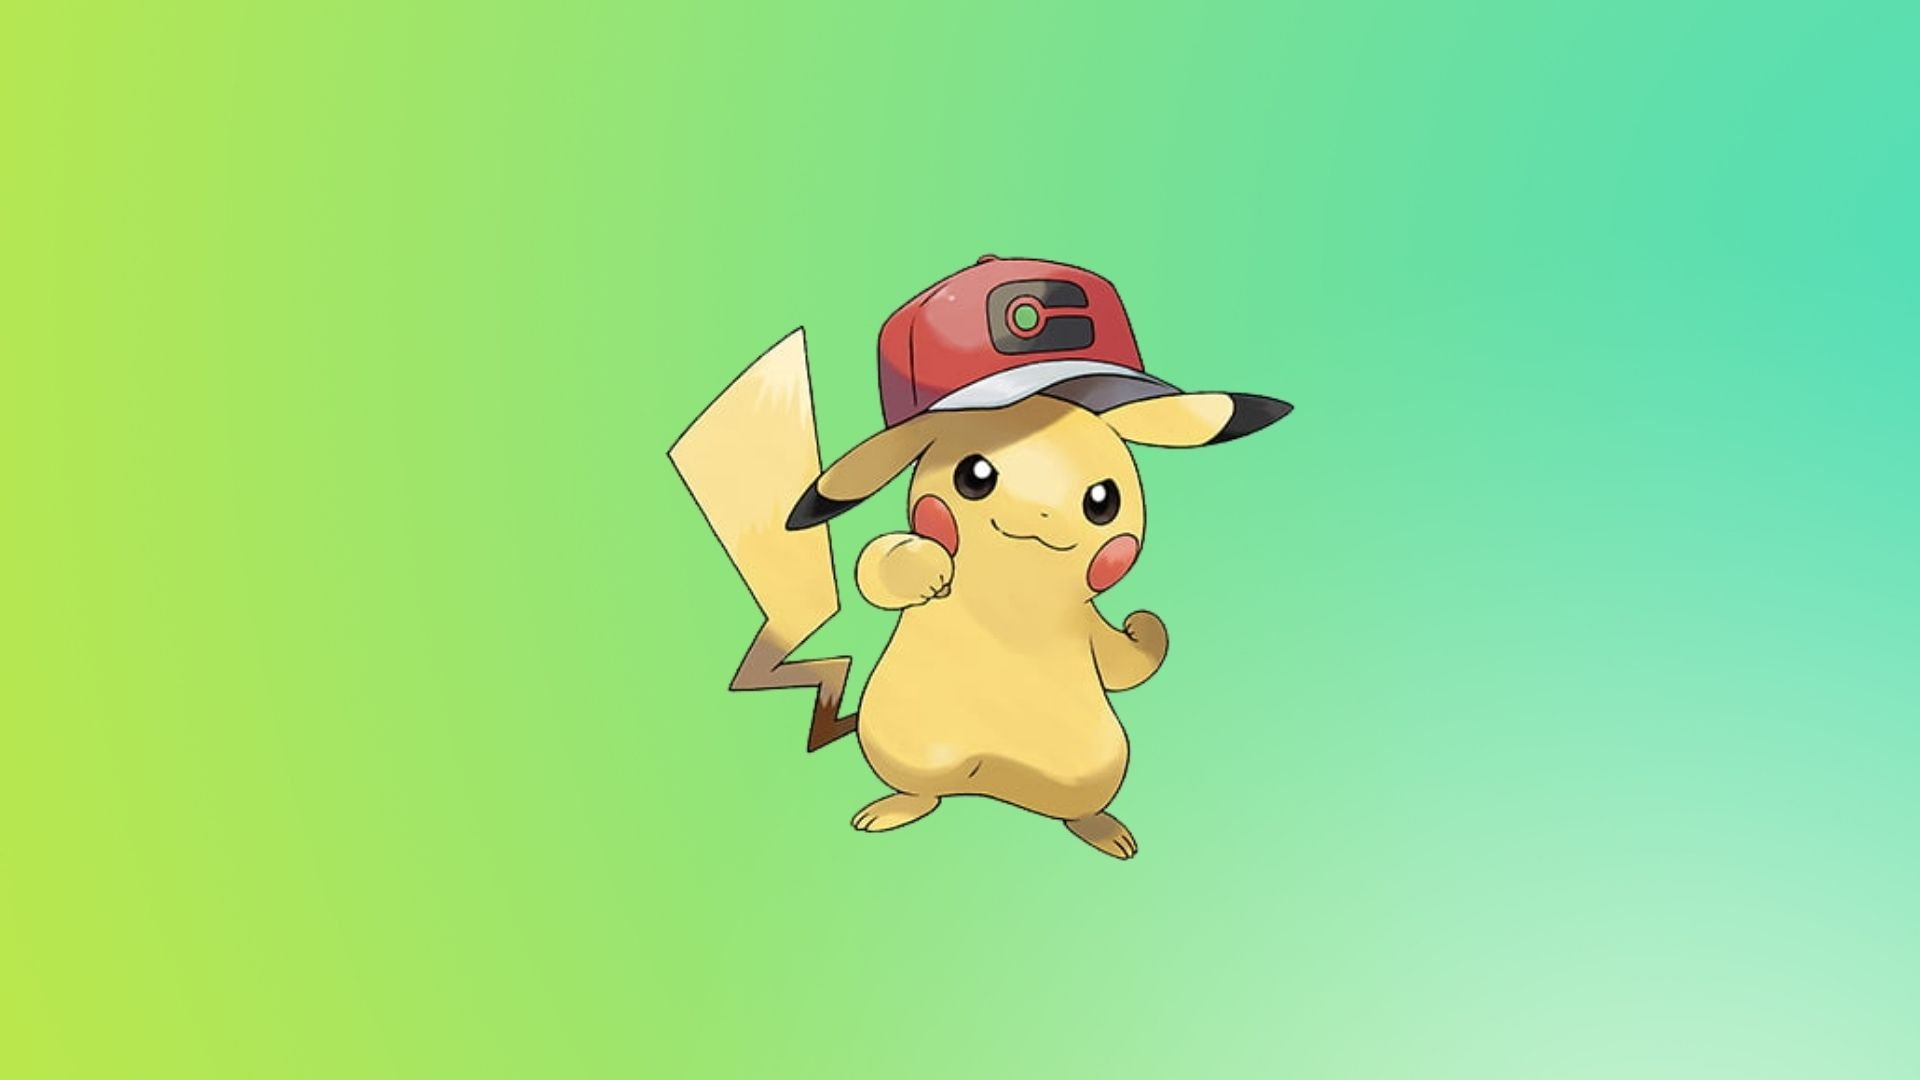

In [ ]:
from PIL import Image
import requests


image_url='https://cdn1.dotesports.com/wp-content/uploads/sites/3/2020/10/30172208/pikachu-world-cap.jpg'
image = Image.open(requests.get(image_url, stream=True).raw)
image

La pasamos por el modelo

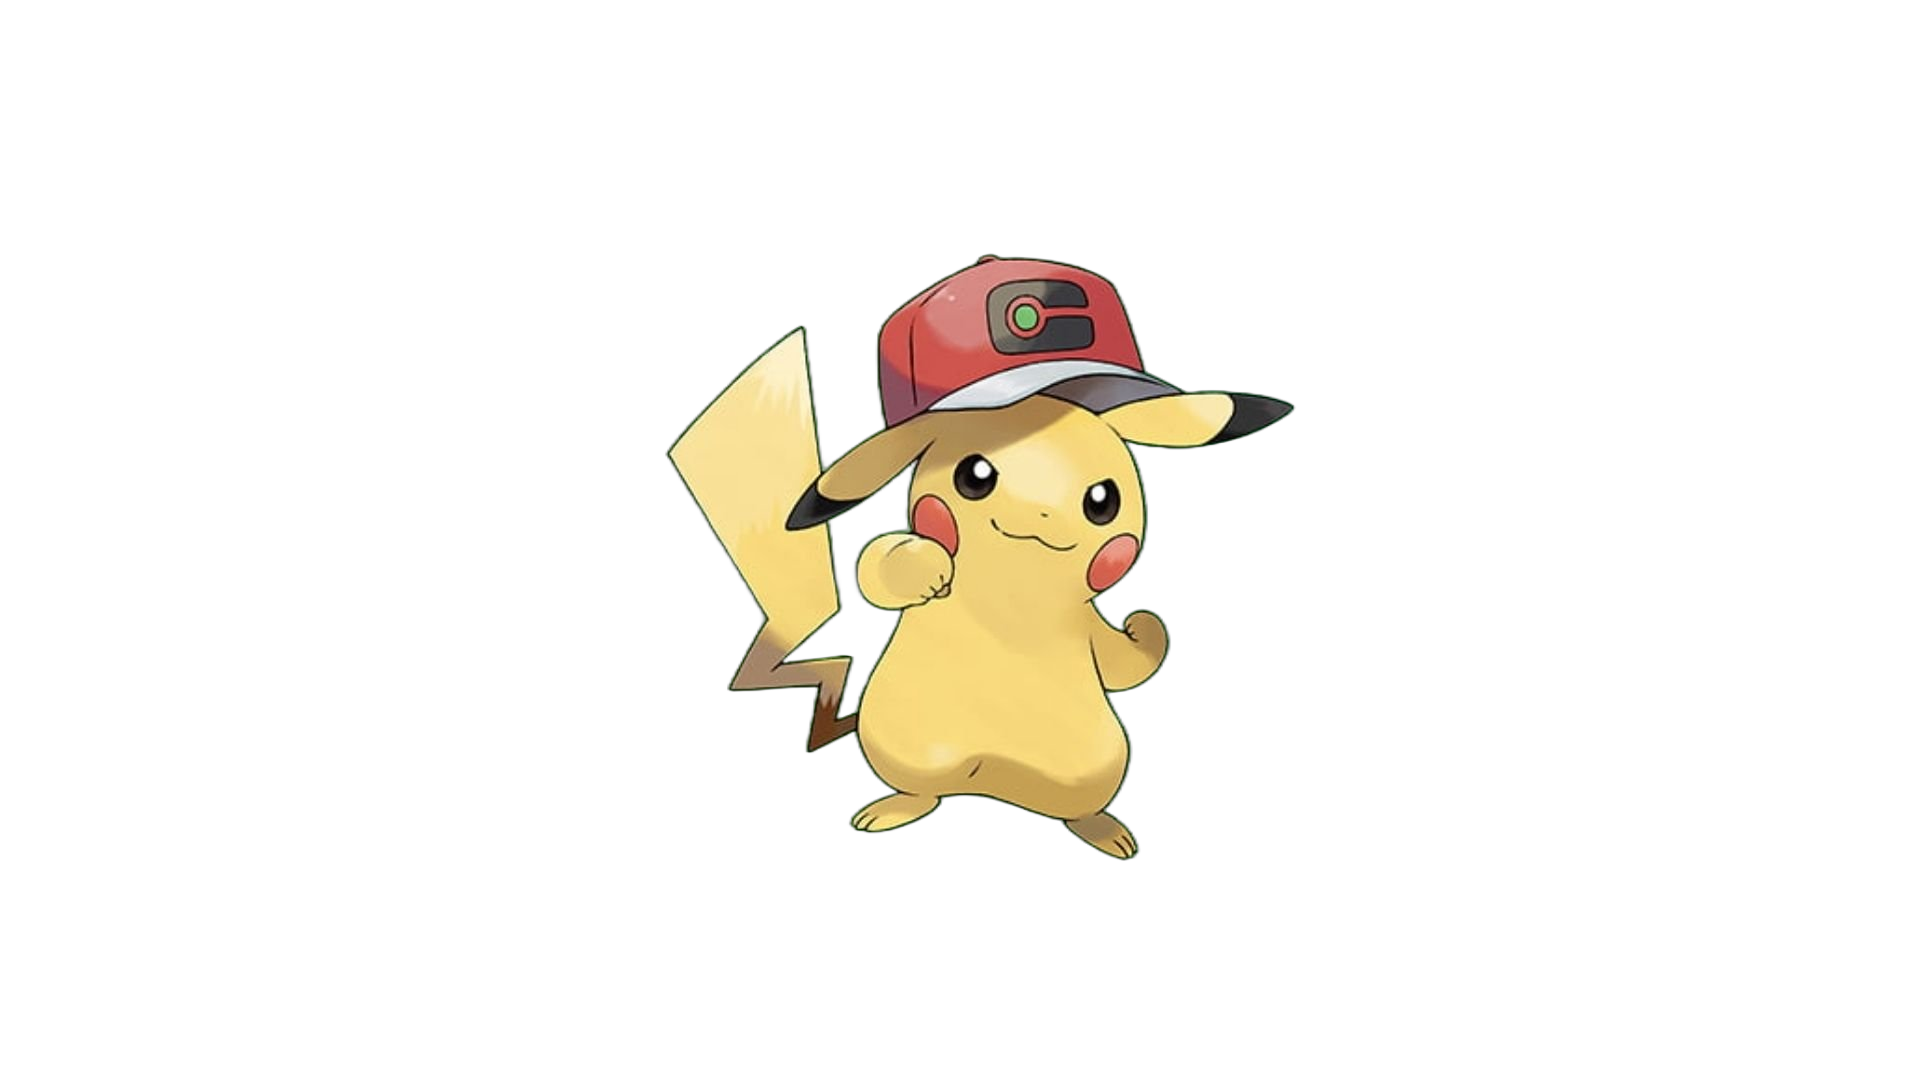

In [ ]:
output = pipe(image)
output

¡Listo! En menos de dos bloques se hizo la tarea

# Usando una librería específica para la tarea

Además de modelos específicos para las tareas, ya existen librerías que simplifican todo el trabajo que lleva crear un modelo, y simplemente te piden por parámetro el modelo a usar.

[RemBG](https://github.com/danielgatis/rembg) es una librería que ya posee la tarea de eliminar fondos de imágenes por medio de modelos de IA como Unet o Sam.

In [ ]:
!pip install rembg

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 49.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.8/86.8 kB 9.9 MB/s eta 0:00:00


In [ ]:
import io
from PIL import Image
import requests

def download_image(url):
  response = requests.get(url, stream=True)
  image = Image.open(io.BytesIO(response.content))
  return image

In [ ]:
from rembg import new_session, remove

model_name = "unet" # https://github.com/danielgatis/rembg?tab=readme-ov-file#models
rembg_session = new_session(model_name)

def remove_bg(url: str):
  image = download_image(url)
  output = remove(image, session=rembg_session)
  return output

100%|███████████████████████████████████████| 176M/176M [00:00<00:00, 52.7GB/s]


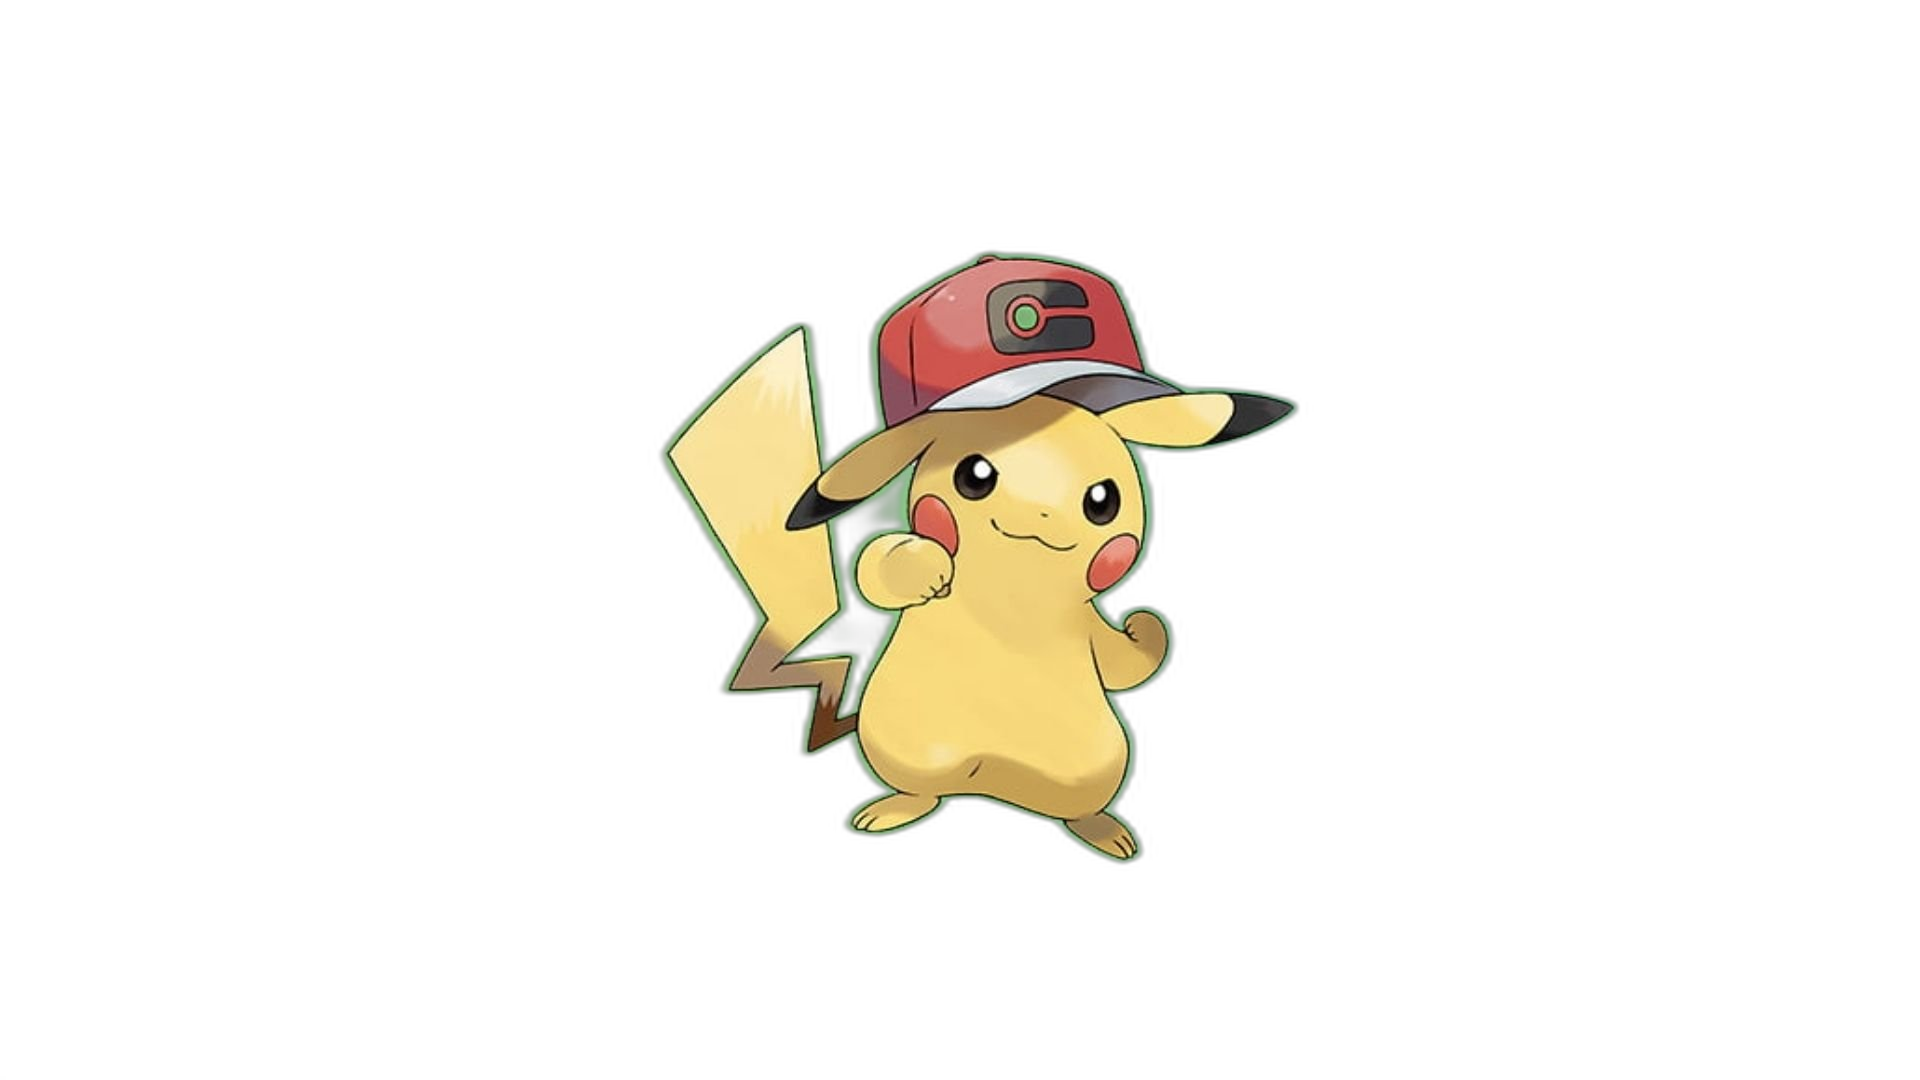

In [ ]:
remove_bg('https://cdn1.dotesports.com/wp-content/uploads/sites/3/2020/10/30172208/pikachu-world-cap.jpg')

# Conclusiones

SAM es un modelo perfecto para segmentar lo que sea, como contra, necesita que se le indique explícitamernte la máscara que debe extraer.

Para eliminar fondos existen otros modelos más expecializados e incluso librerías ya implementadas

# Tu turno

SAM en teoría es capaz de correr en cualquier dispositivo relativamente actual. Usa el modelo para crear una aplicación que al darle click a un objeto, lo busque por internet tal como funciona aplicaciones como Google Lens.